In [ ]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [31]:
!nvidia-smi

Tue May 25 15:26:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    31W /  70W |   4176MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# !unzip /content/drive/MyDrive/Colab\ Notebooks/64x64.zip > /dev/null
# !unzip /content/drive/MyDrive/Colab\ Notebooks/32x32.zip > /dev/null
!unzip /content/drive/MyDrive/Colab\ Notebooks/split_images.zip > /dev/null

In [7]:
## libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sys, os, time, csv, glob, cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Convolution1D, Convolution2D, MaxPooling2D, Flatten, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn import metrics

## Settings
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision = 5, suppress = True)

# CNN 1.0 - Binary output (attack/normal)

In [32]:
train_normal = []
train_attack = []
test_normal = []
test_attack = []

for i in glob.glob('/content/split_images/80-20/train_normal/train_normal_equ_*.jpg', recursive=True):
    train_normal.append(cv2.imread(i, cv2.IMREAD_GRAYSCALE))

for j in glob.glob('/content/split_images/80-20/train_attack/train_attack_equ_*.jpg', recursive=True):
    train_attack.append(cv2.imread(j, cv2.IMREAD_GRAYSCALE))

for k in glob.glob('/content/split_images/80-20/test_normal/test_normal_equ_*.jpg', recursive=True):
    test_normal.append(cv2.imread(k, cv2.IMREAD_GRAYSCALE))

for l in glob.glob('/content/split_images/80-20/test_attack/test_attack_equ_*.jpg', recursive=True):
    test_attack.append(cv2.imread(l, cv2.IMREAD_GRAYSCALE))

train_normal = np.array(train_normal)
train_attack = np.array(train_attack)
test_normal = np.array(test_normal)
test_attack = np.array(test_attack)

In [33]:
np.shape(train_normal), np.shape(train_attack), np.shape(test_normal), np.shape(test_attack)

# for i in range(0, 2):
#   plt.imshow(train_normal[i], cmap = 'gray')
#   plt.show()

# for i in train_normal:
#   print(i)

((1714, 64, 64), (1576, 64, 64), (1714, 64, 64), (394, 64, 64))

In [49]:
## augmenting the data to create more images
## only run cell if needed

## vertically flip training images
vert_flip_train_attack = np.fliplr(train_attack)
vert_flip_train_normal = np.fliplr(train_normal)

## flip training images horizonatally
hor_flip_train_attack = np.rot90(train_attack, axes = (1,2), k = 2)
hor_flip_train_normal = np.rot90(train_normal, axes = (1,2), k = 2)

## rotate training images left and right once each
rotate90l_train_attack = np.rot90(train_attack, axes=(1, 2))
rotate90r_train_attack = np.rot90(train_normal, -1, axes=(1, 2))
rotate90l_train_normal = np.rot90(train_attack, axes=(1, 2))
rotate90r_train_normal = np.rot90(train_normal, -1, axes=(1, 2))



## vertically flip testing images
vert_flip_test_attack = np.fliplr(test_attack)
vert_flip_test_normal = np.fliplr(test_normal)

## flip testing images horizonatally
hor_flip_test_attack = np.rot90(test_attack, axes = (1,2), k = 2)
hor_flip_test_normal = np.rot90(test_normal, axes = (1,2), k = 2)

## rotate testing images left and right once each
rotate90l_test_attack = np.rot90(test_attack, axes=(1, 2))
rotate90r_test_attack = np.rot90(test_normal, -1, axes=(1, 2))
rotate90l_test_normal = np.rot90(test_attack, axes=(1, 2))
rotate90r_test_normal = np.rot90(test_normal, -1, axes=(1, 2))


## stack all the original and augmented data to one single numpy array
# train = np.vstack((train_attack, vert_flip_train_attack, hor_flip_train_attack, rotate90l_train_attack, rotate90r_train_attack,
#                    train_normal, vert_flip_train_normal, hor_flip_train_normal, rotate90l_train_normal, rotate90r_train_normal))
# test = np.vstack((test_attack, vert_flip_test_attack, hor_flip_test_attack, rotate90l_test_attack, rotate90r_test_attack,
#                   test_normal, vert_flip_test_normal, hor_flip_test_normal, rotate90l_test_normal, rotate90r_test_normal))

train = np.vstack((train_attack, vert_flip_train_attack, hor_flip_train_attack,
                   train_normal, vert_flip_train_normal, hor_flip_train_normal))
test = np.vstack((test_attack, vert_flip_test_attack, hor_flip_test_attack,
                  test_normal, vert_flip_test_normal, hor_flip_test_normal))

In [36]:
## if no augmented data is needed, run this cell
train = np.vstack((train_attack, train_normal))
test = np.vstack((test_attack, test_normal))

train.shape, test.shape

((3290, 64, 64), (2108, 64, 64))

In [50]:
train = train.reshape(-1,64,64,1)
test = test.reshape(-1,64,64,1)

train.shape, test.shape

((9870, 64, 64, 1), (6324, 64, 64, 1))

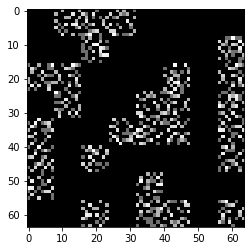

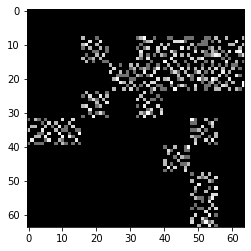

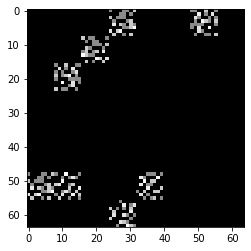

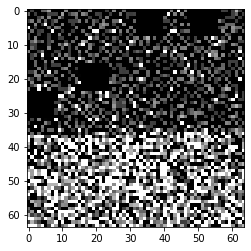

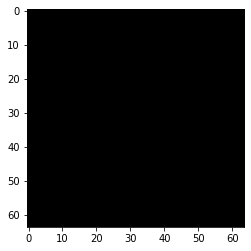

In [38]:
for i in range(0, 5):
    plt.imshow(tf.squeeze(train[i]), cmap = 'gray')
    plt.show()

In [39]:
## create the training and testing data labels
## run if not using augmented data

training_labels = []
## add the attack labels
for i in range(0, train_attack.shape[0]):
    training_labels.append('attack')

## add the normal labels
for j in range(train_attack.shape[0], train.shape[0]):
    training_labels.append('normal')



testing_labels = []
## add the attack labels
for k in range(0, test_attack.shape[0]):
    testing_labels.append('attack')

## add the normal labels
for l in range(test_attack.shape[0], test.shape[0]):
    testing_labels.append('normal')

In [ ]:
## create the training and testing data labels
## run this cell if using augmented data with rotated data

training_labels = []
## add the attack labels
for i in range(0, train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0] + rotate90l_train_attack.shape[0] + rotate90r_train_attack.shape[0]):
    training_labels.append('attack')

## add the normal labels
for j in range(train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0] + rotate90l_train_attack.shape[0] + rotate90r_train_attack.shape[0], train.shape[0]):
    training_labels.append('normal')



testing_labels = []
## add the attack labels
for k in range(0, test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0] + rotate90l_test_attack.shape[0] + rotate90r_test_attack.shape[0]):
    testing_labels.append('attack')

## add the normal labels
for l in range(test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0] + rotate90l_test_attack.shape[0] + rotate90r_test_attack.shape[0], test.shape[0]):
    testing_labels.append('normal')

In [51]:
## create the training and testing data labels
## run this cell if using augmented data and not with rotated data

training_labels = []
## add the attack labels
for i in range(0, train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0]):
    training_labels.append('attack')

## add the normal labels
for j in range(train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0], train.shape[0]):
    training_labels.append('normal')



testing_labels = []
## add the attack labels
for k in range(0, test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0]):
    testing_labels.append('attack')

## add the normal labels
for l in range(test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0], test.shape[0]):
    testing_labels.append('normal')

In [52]:
## create the dataframe for labels, then OHE the column
ytrain = pd.DataFrame(training_labels, columns = ['category'])
ytest = pd.DataFrame(testing_labels, columns = ['category'])

ytrain = pd.get_dummies(ytrain['category'])
ytest = pd.get_dummies(ytest['category'])

ytrain, ytest

(      attack  normal
 0          1       0
 1          1       0
 2          1       0
 3          1       0
 4          1       0
 ...      ...     ...
 9865       0       1
 9866       0       1
 9867       0       1
 9868       0       1
 9869       0       1
 
 [9870 rows x 2 columns],       attack  normal
 0          1       0
 1          1       0
 2          1       0
 3          1       0
 4          1       0
 ...      ...     ...
 6319       0       1
 6320       0       1
 6321       0       1
 6322       0       1
 6323       0       1
 
 [6324 rows x 2 columns])

In [53]:
## shuffle the data to prevent pattern recognition
train, ytrain = sklearn.utils.shuffle(train, ytrain, random_state = 7)
test, ytest = sklearn.utils.shuffle(test, ytest, random_state = 7)

In [54]:
KERNEL_SIZE = [2,2]
IMAGE_SIZE = [64,64,1]

cnn = Sequential()

## convolution 1
cnn.add(Convolution2D(2**4, (KERNEL_SIZE), padding="same", activation='relu', input_shape = (IMAGE_SIZE)))
cnn.add(MaxPooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.25))

## convolution 2
cnn.add(Convolution2D(2**5, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(MaxPooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.25))

## convolution 3
cnn.add(Convolution2D(2**6, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(MaxPooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.25))

## convolution 4
cnn.add(Convolution2D(2**7, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(MaxPooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

## convolution 5
# cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
# cnn.add(AveragePooling2D(pool_size = (2,2)))
# # cnn.add(Dropout(0.5))

# ## convolution 6
# cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
# cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

cnn.add(Flatten())

## dense
# cnn.add(Dense(256, activation='relu'))
cnn.add(Dense(128, activation='relu'))
# cnn.add(Dense(64, activation='relu'))
# cnn.add(Dense(256, activation='relu'))
# cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation = 'sigmoid'))

# callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

cnn.compile(optimizer = keras.optimizers.Adam(), loss = 'binary_crossentropy',
            metrics = ['accuracy'])


cnn.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 64, 64, 16)        80        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 32, 32, 32)        2080      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 16, 16, 64)        8256      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 8, 8, 128)        

In [55]:
start = time.time()
model_history = cnn.fit(train, ytrain, batch_size = 512, epochs = 300)
end = time.time()

# os.system(f'say "training finished in {round(end - start, 2)} seconds"')
print(f'Training finished in {round(end - start, 2)}')

Epoch 1/300
20/20 [==============================] - 1s 47ms/step - loss: 4.9326 - accuracy: 0.5645
Epoch 2/300
20/20 [==============================] - 1s 33ms/step - loss: 0.6798 - accuracy: 0.6524
Epoch 3/300
20/20 [==============================] - 1s 33ms/step - loss: 0.6422 - accuracy: 0.6705
Epoch 4/300
20/20 [==============================] - 1s 32ms/step - loss: 0.6040 - accuracy: 0.6696
Epoch 5/300
20/20 [==============================] - 1s 33ms/step - loss: 0.5934 - accuracy: 0.6751
Epoch 6/300
20/20 [==============================] - 1s 32ms/step - loss: 0.5739 - accuracy: 0.7004
Epoch 7/300
20/20 [==============================] - 1s 33ms/step - loss: 0.5668 - accuracy: 0.7064
Epoch 8/300
20/20 [==============================] - 1s 33ms/step - loss: 0.5466 - accuracy: 0.7216
Epoch 9/300
20/20 [==============================] - 1s 33ms/step - loss: 0.5315 - accuracy: 0.7346
Epoch 10/300
20/20 [==============================] - 1s 33ms/step - loss: 0.5170 - accuracy: 0.7459

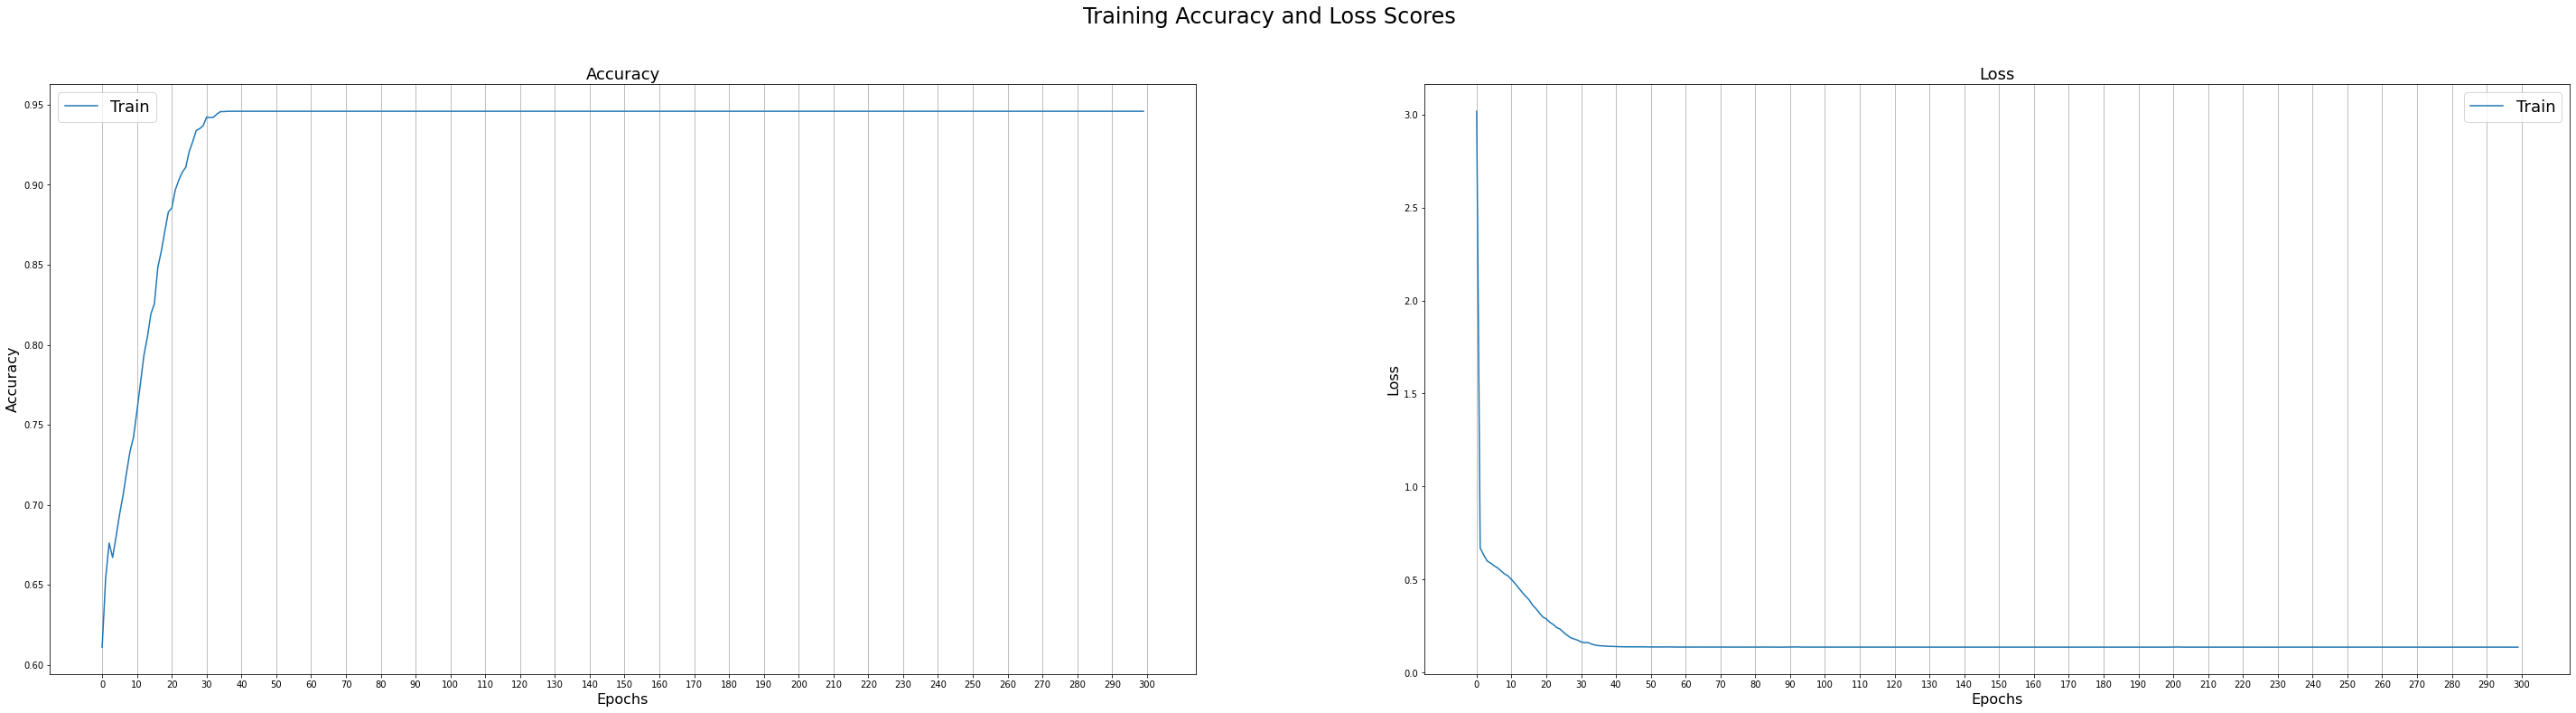

In [56]:
# print(model_history.history.keys())
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(50,12))
fig.suptitle('Training Accuracy and Loss Scores', fontsize = 24)

axes[0].plot(model_history.history['accuracy'])
axes[0].set_title('Accuracy', fontsize = 18)
axes[0].set_ylabel('Accuracy', fontsize = 16)
axes[0].set_xlabel('Epochs', fontsize = 16)
axes[0].set_xticks(np.arange(0, 310, step = 10))
axes[0].grid(axis = 'x')
axes[0].legend(['Train', 'Test'], loc = 'best', fontsize = 18)

axes[1].plot(model_history.history['loss'])
axes[1].set_title('Loss', fontsize = 18)
axes[1].set_ylabel('Loss', fontsize = 16)
axes[1].set_xlabel('Epochs', fontsize = 16)
axes[1].set_xticks(np.arange(0, 310, step = 10))
axes[1].grid(axis = 'x')
axes[1].legend(['Train', 'Test'], loc = 'best', fontsize = 18)

In [57]:
loss, acc = cnn.evaluate(test, ytest, batch_size = 512, verbose = 0)
print(f'Loss = {round(loss, 4)}\tAccuracy = {round(acc, 4)*100}%')

Loss = 0.6337	Accuracy = 91.79%


In [58]:
preds = cnn.predict(test)
y_preds = np.argmax(preds, axis = 1)

preds[:20]

array([[0.19499, 0.80516],
       [0.19499, 0.80516],
       [0.     , 1.     ],
       [0.19499, 0.80516],
       [1.     , 0.     ],
       [0.19499, 0.80516],
       [0.00026, 0.99976],
       [0.19499, 0.80516],
       [0.     , 1.     ],
       [0.19499, 0.80516],
       [0.00003, 0.99999],
       [0.19499, 0.80516],
       [0.     , 1.     ],
       [0.19499, 0.80516],
       [0.19499, 0.80516],
       [0.19499, 0.80516],
       [0.19499, 0.80516],
       [0.00001, 0.99998],
       [0.19499, 0.80516],
       [1.     , 0.00001]], dtype=float32)

In [59]:
def build_classifier():
    
    cnn = Sequential()

    ## convolution 1
    cnn.add(Convolution2D(2**4, (KERNEL_SIZE), padding="same", activation='relu', input_shape = (IMAGE_SIZE)))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 2
    cnn.add(Convolution2D(2**5, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 3
    cnn.add(Convolution2D(2**6, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 4
    cnn.add(Convolution2D(2**7, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # # cnn.add(Dropout(0.5))

    ## convolution 5
    # cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
    # cnn.add(AveragePooling2D(pool_size = (2,2)))
    # # # cnn.add(Dropout(0.5))

    # ## convolution 6
    # cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
    # cnn.add(AveragePooling2D(pool_size = (2,2)))
    # # cnn.add(Dropout(0.5))

    cnn.add(Flatten())

    ## dense
    # cnn.add(Dense(256, activation='relu'))
    cnn.add(Dense(128, activation='relu'))
    # cnn.add(Dense(64, activation='relu'))
    # cnn.add(Dense(32, activation='relu'))
    # cnn.add(Dropout(0.5))
    cnn.add(Dense(2, activation = 'sigmoid'))

    # callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

    cnn.compile(optimizer = keras.optimizers.Adam(), loss = 'binary_crossentropy',
                metrics = ['accuracy'])
    
    return cnn

classifier = KerasClassifier(build_fn = build_classifier, batch_size = 512, epochs = 300)

In [60]:
from sklearn.model_selection import KFold

kf = KFold(n_splits = 5, random_state = None)
score = cross_val_score(classifier, test, ytest, cv = kf)
print(f'Model Cross Validation: \n{round(score.mean(), 3)*100}%')
print(f'Model Cross Validation: \n{score}')

Epoch 1/300
10/10 [==============================] - 1s 86ms/step - loss: 0.8618 - accuracy: 0.6425
Epoch 2/300
10/10 [==============================] - 0s 32ms/step - loss: 0.5938 - accuracy: 0.8168
Epoch 3/300
10/10 [==============================] - 0s 32ms/step - loss: 0.4858 - accuracy: 0.8143
Epoch 4/300
10/10 [==============================] - 0s 32ms/step - loss: 0.4521 - accuracy: 0.8080
Epoch 5/300
10/10 [==============================] - 0s 32ms/step - loss: 0.4422 - accuracy: 0.8105
Epoch 6/300
10/10 [==============================] - 0s 32ms/step - loss: 0.4311 - accuracy: 0.8187
Epoch 7/300
10/10 [==============================] - 0s 31ms/step - loss: 0.4431 - accuracy: 0.8078
Epoch 8/300
10/10 [==============================] - 0s 32ms/step - loss: 0.4273 - accuracy: 0.8141
Epoch 9/300
10/10 [==============================] - 0s 32ms/step - loss: 0.4218 - accuracy: 0.8149
Epoch 10/300
10/10 [==============================] - 0s 31ms/step - loss: 0.4165 - accuracy: 0.8263